# Pràctica 1: Anàlisi i classificació del dataset del Titanic

Nerea de la Torre Veguillas (1669013), Mara Montero Jurado (1671506), Júlia Morán Fluvià (1667730) i Adrián Prego Gallart (1672251)

### 1. Importació de biblioteques i carga de dades

In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as bplt
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, r2_score, confusion_matrix, average_precision_score, precision_recall_curve, auc, roc_curve,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

In [191]:
test_kaggle = pd.read_csv(f'C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/Practica1/titanic/test.csv')
train = pd.read_csv(f'C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/Practica1/titanic/train.csv')

### 1. Anàlisi exploratori de dades (EDA)

La nostra base de dades té 12 atributs, 5 dels quals són categorics i  6 són numèrics 
- Numèrics: Name, Sex, Ticket, Cabin, Embarked
- Categòrics: PassengerId, Pclass, Age, SibSp, Parch, Fare

El nostre target que és Survived, un atribut binari, el qual el valor 1 ens indica que el passatger va sobreviure i 0 que no. 


Amb els gràfics podem observar com tenim una correlació entre el sexe i la classe amb si els passatgers van sobreviure o no. En el cas del sexe, veiem com les dones van sobreviure amb una proporció superior als homes. A més, observem com a major fos la classe que el passatger tenia, més persones van sobreviure, indicant així com els passatgers amb major poder adquisitiu van sobreviure més. En el cas de les dones que estaven en primera classe, practicament totes van sobreviure. 

In [192]:
print("Número d'atributs del dataset:", len(train.keys()))
print("Número de files en el train (mostres): ",train.shape[0])

print("\nAtributs del dataset i el seu tipus:")
print (train.dtypes) 

Número d'atributs del dataset: 12
Número de files en el train (mostres):  891

Atributs del dataset i el seu tipus:
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


In [193]:
print("\nMirem descripció general:")
print (train.describe())


Mirem descripció general:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [194]:
nan_columns = train.columns[train.isna().sum()>0].tolist() #columnes q falta 1 o més valors al datset
print('NÚMERO DE NANS PER COLUMNA:')
print (train.loc[:,nan_columns].isna().sum()) #numero de nans per columna
print('\nPERCENTATGES DE NANS PER COLUMNA:')
print (train.loc[:,nan_columns].isna().sum()/len(train)*100) #percentatge de nans per columna


NÚMERO DE NANS PER COLUMNA:
Age         177
Cabin       687
Embarked      2
dtype: int64

PERCENTATGES DE NANS PER COLUMNA:
Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64


Trobem Nans en els atributs Age, Cabin i Embarked, els quals més endavant solucionem.

Ara analitzarem les dades mitjançant gràfics per veure  correlacions, proporcions.. i extreure conclusions prèvies a l'anàlisi:

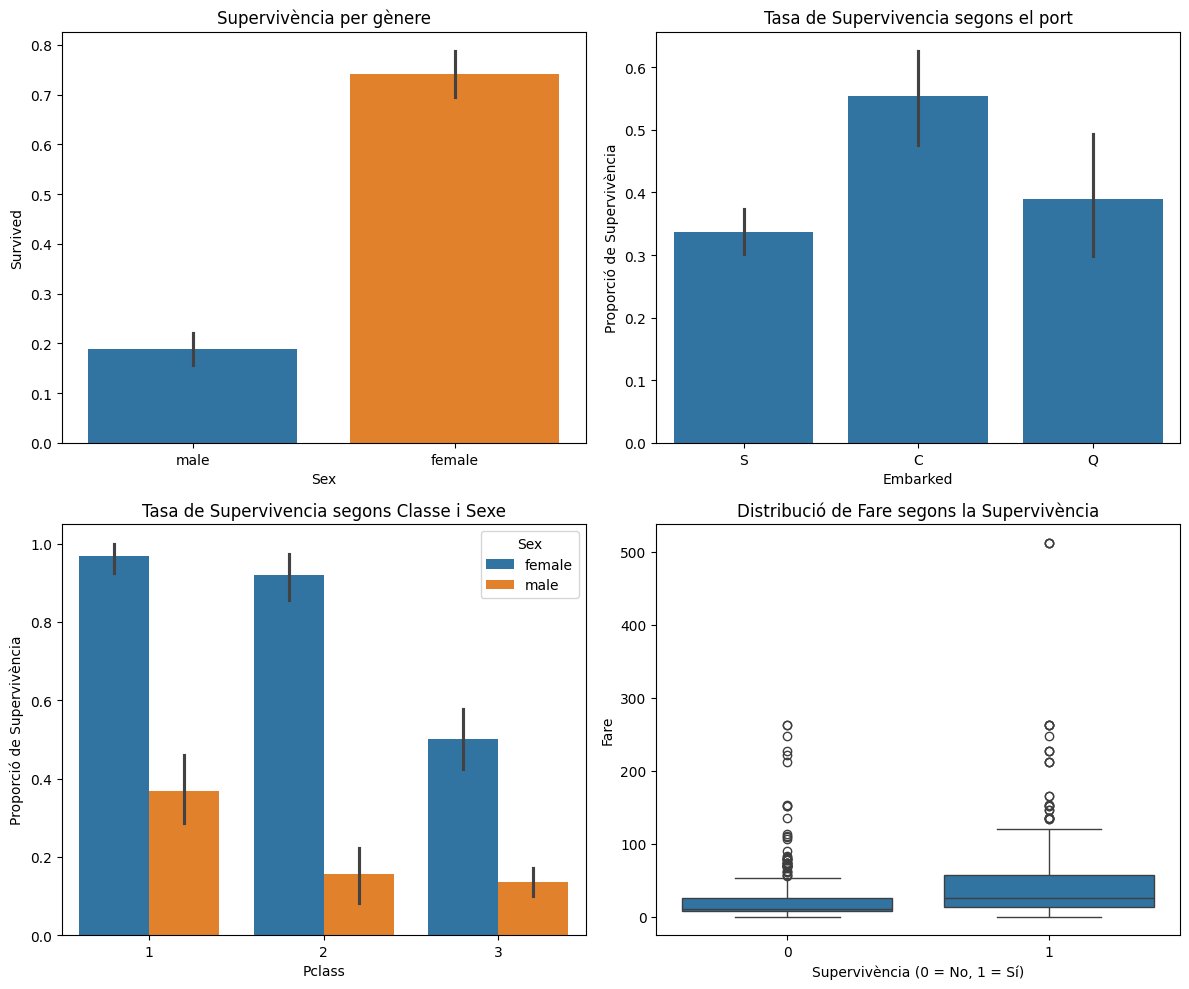

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.barplot(x="Sex", y="Survived", hue='Sex', data=train, ax=axes[0, 0])
axes[0, 0].set_title("Supervivència per gènere")

sns.barplot(x="Embarked", y="Survived", data=train, ax=axes[0, 1])
axes[0, 1].set_title('Tasa de Supervivencia segons el port')
axes[0, 1].set_ylabel('Proporció de Supervivència')

sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train, ax=axes[1, 0])
axes[1, 0].set_title('Tasa de Supervivencia segons Classe i Sexe')
axes[1, 0].set_ylabel('Proporció de Supervivència')


sns.boxplot(x='Survived', y='Fare', data=train)
axes[1, 1].set_title('Distribució de Fare segons la Supervivència')
axes[1, 1].set_ylabel('Fare')
axes[1, 1].set_xlabel('Supervivència (0 = No, 1 = Sí)')

plt.tight_layout()
plt.show()



Les conclusions que podem extreure sobre els gràfics de correlació són:
- En el primer gràfic podem observar com les dones són més propenses a sobreviure.
- En el segon gràfic veiem que sobreviuen més els que embarquen en el port C.
- En el tercer gràfic, les classes més altes  sobreviuen més. La tasa de supervivència entre la classe i el sexe és major en el cas de les dones de primera classe, com hem observat amb els dos gràfics anteriors.
- Per últim, amb aquest gràfic tornem a afirmar que els passatgers que més van pagar van sobreviure amb major proporció que els que tenien un bitllet amb un preu baix (tercera classe).

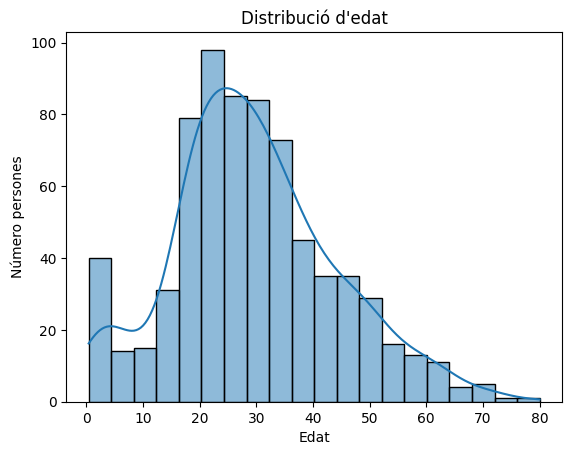

In [196]:
sns.histplot(data=train, x='Age', kde=True)
bplt.title('Distribució d\'edat')
bplt.xlabel('Edat')
bplt.ylabel('Número persones')
bplt.show()

D'aqui podem extreure que els joves són més propensos a sobreviure, ja que són l'edat majoritària.

In [197]:
attributes = [k for k in train.keys() if k!='Survived']
y = train['Survived'].to_numpy()

print("El percentatge es", y.mean(), "% de supervivents per al train. No esta balancejada però no és crític.")

El percentatge es 0.3838383838383838 % de supervivents per al train. No esta balancejada però no és crític.


Les etiquetes no estan balancejades, ja que el percentatge de supervivents és de 38,38% pel train. Encara que no estiguin balancejades, no és un cas crític, i ho podrem solucionr fent k-fold cross validation.

Survived
0    549
1    342
Name: count, dtype: int64


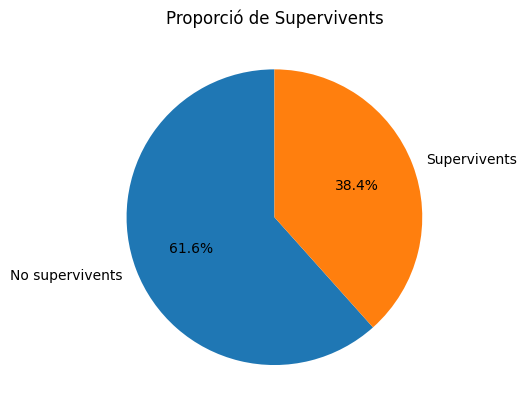

In [284]:
survival_counts = train['Survived'].value_counts()
print(survival_counts)
bplt.pie(survival_counts, labels=['No supervivents', 'Supervivents'], autopct='%1.1f%%', startangle=90)
bplt.title('Proporció de Supervivents')
bplt.show()

### 2. Preprocessament de les dades (normalitzation, outlier removal, feature selection..)

En aquest apartat, s'ha netejat i transformat el conjunt de dades per preparar-lo per a l'entrenament del model.

Sabem que alguns mètodes de classifiació no admeten Nans, com el SVM. Com javiem vist abans, tenim tres atributs amb nans: age, cabin i embarked:

Age(9.87% NaNs), Embarked(0.22% NaNs) i Cabin(77.1% NaNs).

Primer, s'han eliminat les columnes considerades irrellevants per a la predicció: 'Name', 'PassengerId', 'Ticket' y 'Cabin'. Les tres primeres pel fet que són identificadors únics i per tant no són rellevants, i 'Cabin' pel gran percentatge de NaNs que contenia (més d'un 77%).

A continuació, s'han identificat els atributs categòrics i numèrics del conjunt de dades. Per a la variable categòrica 'Sex', s'ha aplicat Label Encoding per convertir-la en valors numèrics (0 i 1). 

Per omplir els NaNs de 'Embarked' s'han omplert els valors nuls mitjançant KNN en funció dels atributs de Plass i Sex, i posteriorment s'ha transformat utilitzant One-Hot Encoding, creant 3 columnes binàries per a cada possible valor de 'Embarked'.
Per omplir els NaNs de Age, utilitzarem el promig d'edat en funció dels atributs de Plass i Sex.

In [199]:
#eliminem atributs irrellevants:
columns_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId']
train_clean = train.drop(columns=columns_to_drop)

#transformem atributs categorics a numerics:
numeric_features = train_clean.select_dtypes(np.number).keys()
non_numeric = [k for k in train_clean.keys() if k not in numeric_features]
print("Numeric features: ", numeric_features)
print("Non numeric features: ", non_numeric)

#pel cas de sex, utilitxem label encoding

label_encoder = LabelEncoder()
train_clean['Sex'] = label_encoder.fit_transform(train_clean['Sex'])

#pel cas de embarked, utilitxem One-Hot Encoding
#pero primer reomplim els nans:


train_clean['Embarked'] = train_clean['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})  # Convertir 'Embarked' a valors numèrics temporals per poder aplicar KNN
imputer = KNNImputer(n_neighbors=5)
train_clean['Embarked'] = imputer.fit_transform(train_clean[['Embarked', 'Sex', 'Pclass']])
train_clean['Embarked'] = train_clean['Embarked'].map({0: 'S', 1: 'C', 2: 'Q'}) # Tornar a convertir 'Embarked' a les seves representacions categòriques originals

#ara q no tenim nans, fem onehot encoding
train_clean = pd.get_dummies(train_clean, columns=['Embarked'])
train_clean[["Embarked_Q", "Embarked_S", "Embarked_C"]] = train_clean[["Embarked_Q", "Embarked_S", "Embarked_C"]].astype(int)

#reomplim Nans de age amb la mitjana segons la pclass i la age:
grups = train_clean.groupby(['Pclass','Sex'])['Age'].mean().reset_index()[['Sex', 'Pclass', 'Age']]
def fill_age(x):
    return grups[(grups.Pclass==x.Pclass)&(grups.Sex==x.Sex)]['Age'].values[0]

train_clean['Age'] = train_clean.apply(lambda x: fill_age(x) if np.isnan(x['Age']) else x['Age'], axis=1)
print(train_clean.head)

Numeric features:  Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Non numeric features:  ['Sex', 'Embarked']
<bound method NDFrame.head of      Survived  Pclass  Sex    Age  SibSp  Parch     Fare  Embarked_C  \
0           0       3    1  22.00      1      0   7.2500           0   
1           1       1    0  38.00      1      0  71.2833           1   
2           1       3    0  26.00      0      0   7.9250           0   
3           1       1    0  35.00      1      0  53.1000           0   
4           0       3    1  35.00      0      0   8.0500           0   
..        ...     ...  ...    ...    ...    ...      ...         ...   
886         0       2    1  27.00      0      0  13.0000           0   
887         1       1    0  19.00      0      0  30.0000           0   
888         0       3    0  21.75      1      2  23.4500           0   
889         1       1    1  26.00      0      0  30.0000           1   
890         0       3    1  32.00    

Veiem també interessant analitzar si tenir família a bord en el titanic va influir en la supervivència (creiem que si). Ho comprobem:

In [200]:
train_clean['HasFamily'] = ((train_clean['SibSp'] > 0) | (train_clean['Parch'] > 0)).astype(int)

<Axes: >

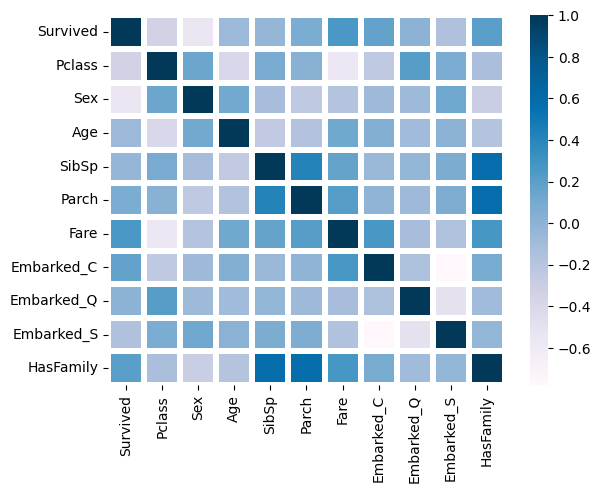

In [201]:
sns.heatmap(train_clean.corr(),cmap="PuBu", edgecolor = "#1c1c1c", linewidth = 3)

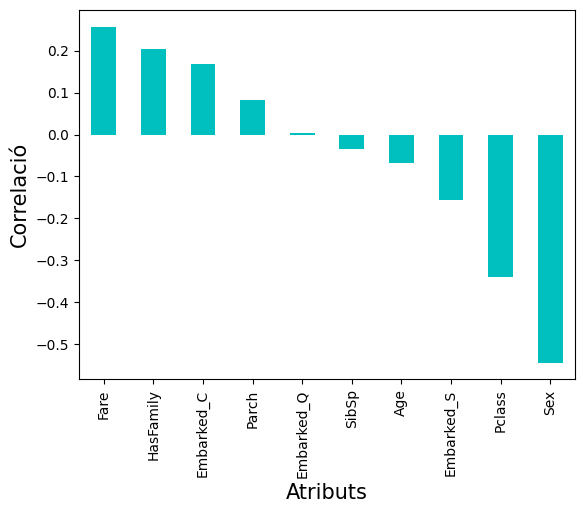

In [202]:
train_clean.corr()['Survived'].sort_values(ascending = False).drop(['Survived']).plot(kind = 'bar', color = 'c')
bplt.xlabel('Atributs', fontsize = 15)
bplt.ylabel('Correlació', fontsize = 15)
bplt.show()

Podem observar que tenir familia si que influeix bastant.

En el procés de normalització que hem realitzat, volíem aplicar estandardització (Z-score) a les variables 'Fare' i 'Age' ja que presenten diferències importants a les seves escales. 

Un cop verificat que la variable 'Age' té una distribució més o menys normal, mitjançant els gràfics Q-Q plot, hem aplicat l'estandardització utilitzant l'escala StandardScaler assegurant així que la variable tingui valors a la mateixa escala. Per altre banda, 'Fare' no segueix exactament una distribució normal, però ho normalitzem perquè més endavant obtenim millors resultats tenint en compte aquest atribut que no pas eliminant-lo.

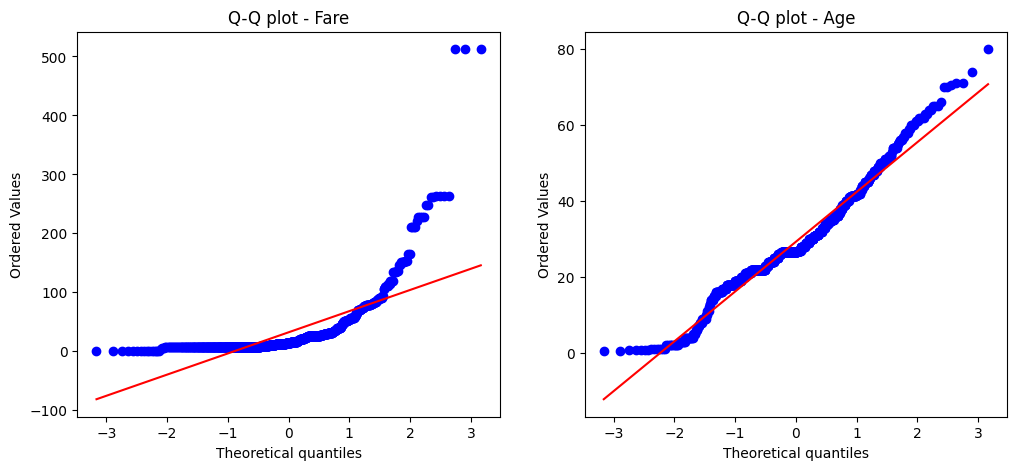

     Survived  Pclass  Sex       Age  SibSp  Parch      Fare  Embarked_C  \
0           0       3    1 -0.551366      1      0 -0.502445           0   
1           1       1    0  0.654030      1      0  0.786845           1   
2           1       3    0 -0.250017      0      0 -0.488854           0   
3           1       1    0  0.428018      1      0  0.420730           0   
4           0       3    1  0.428018      0      0 -0.486337           0   
..        ...     ...  ...       ...    ...    ...       ...         ...   
886         0       2    1 -0.174680      0      0 -0.386671           0   
887         1       1    0 -0.777378      0      0 -0.044381           0   
888         0       3    0 -0.570201      1      2 -0.176263           0   
889         1       1    1 -0.250017      0      0 -0.044381           1   
890         0       3    1  0.202006      0      0 -0.492378           0   

     Embarked_Q  Embarked_S  HasFamily  
0             0           1          1  
1    

In [203]:
#NORMALITZACIO

#Utilitzant Estandarización (Z-score)
#Comprobem si seguiexen una normal:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(train_clean['Fare'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q plot - Fare')

plt.subplot(1, 2, 2)
stats.probplot(train_clean['Age'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q plot - Age')

plt.show()


train_norm = pd.DataFrame(train_clean)
scaler = StandardScaler()
train_norm[['Fare', 'Age']] = scaler.fit_transform(train_norm[['Fare', 'Age']])

print(train_norm)

El PCA és útil quan es treballa amb un conjunt de dades que inclou moltes variables numèriques i es vol reduir el nombre de dimensions sense perdre massa informació. En el nostre cas, no l’hem considerat perquè només tenim 4 variables numèriques (Edat, Preu del bitllet, Germans/Cònjuges a bord i Pares/Fills a bord).

Pros i contres:

- El PCA ajuda a reduir la quantitat de variables resumint-les en un grup més petit de components principals.
- Si les variables originals estiguessin fortament correlacionades, el PCA podria ser útil per reduir aquesta multicol·linearitat.
- Utilitzar PCA pot complicar la interpretació i dificultar l’assignació d’importància a cada variable en el context específic del problema.
- Quan hi ha poques variables numèriques, com en el nostre cas, aplicar PCA no és gaire útil.







### 3. Selecció de la mètrica i el model

In [204]:
attributes = [k for k in train_norm.keys() if k!='Survived']

X = train_norm[attributes]
y = train_norm[['Survived']].values.ravel()

Quan treballem amb dades desbalancejades, l'accuracy_score pot ser enganyós, ja que pot donar la falsa impressió d'un alt rendiment a causa de la presència d'un nom major d'instàncies d'una classe. Per exemple, si una classe constitueix el 90% dels dades, un model que sempre la predigués tindria una precisió del 90%, però no adequada per identificar la classe menys freqüent.

En el nostre dataset, el f1_score és la opció més adequada, ja que utilitza tant la precisió com el recall, i això és  beneficiós en casos de desigualtat entre els classes, ja que considera tant els falsos positius com els falsos negatius. A més a més, com el nostre objectiu és identificar millor les persones que sobreviuen, és a dir, minimitzar els falsos negatius (aquells que el model no identifica com a supervivents quan realment ho són), llavors l'F1 Score seria una mètrica més adequada.

Fem una regressió logística per provar les mètriques:

In [205]:
lr = LogisticRegression(fit_intercept = True)
lr.fit(X,y)

y_pred = lr.predict(X)
classification = classification_report(y, y_pred)

print("Provem les diferents mètriques: ")
f1 = f1_score(y, y_pred)
accuracy = accuracy_score(y, y_pred)
average = average_precision_score(y, y_pred)

print (classification)
print ("F1 score: ", f1)
print ("Accuracy score: ", accuracy)
print ("Average precision score: ", average)

Provem les diferents mètriques: 
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       549
           1       0.78      0.71      0.74       342

    accuracy                           0.81       891
   macro avg       0.80      0.79      0.80       891
weighted avg       0.81      0.81      0.81       891

F1 score:  0.7419847328244275
Accuracy score:  0.8103254769921436
Average precision score:  0.6627337780019804


aqui va lo del adri

Mirem les corbes ROC i PR:

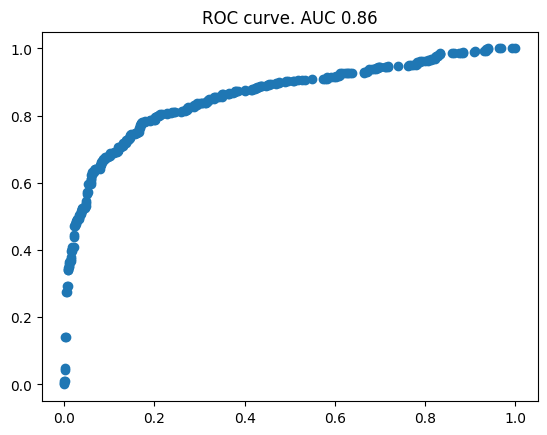

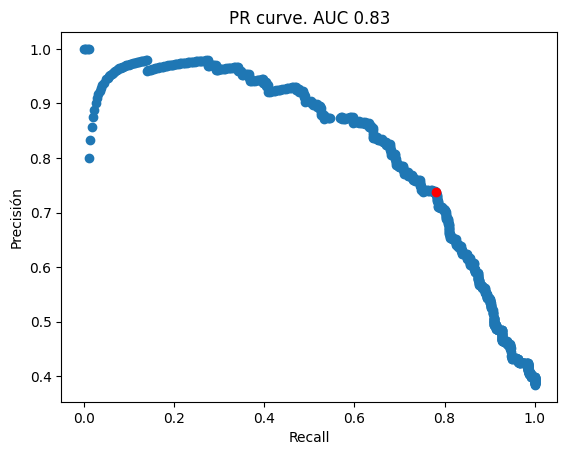

In [206]:

probs = lr.predict_proba(X)

#ROC CURVE
fpr, tpr, _ = roc_curve(y, probs[:,1])
auc_roc = roc_auc_score(y,probs[:,1])

plt.scatter(fpr,tpr)
plt.title(f'ROC curve. AUC {round(auc_roc,2)}')
plt.show()


#PR CURVE
prec, rec, _ = precision_recall_curve(y, probs[:,1])
auc_pr = auc(rec,prec)

# Calcular el F1-score para cada punto en la curva de precisión-recall
f1_scores = 2 * (prec * rec) / (prec + rec)

# Encontrar el índice del F1-score máximo
idx_max_f1 = np.argmax(f1_scores)
max_f1 = f1_scores[idx_max_f1]
best_prec = prec[idx_max_f1]
best_rec = rec[idx_max_f1]

# Graficar la curva PR y el punto óptimo
plt.scatter(rec,prec)
plt.scatter(best_rec, best_prec, color='red', label=f'Goal: Precision={round(best_prec, 2)}, Recall={round(best_rec, 2)}, F1={round(max_f1, 2)}')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title(f'PR curve. AUC {round(auc_pr,2)}')
plt.show()


La corba ROC (Receiver Operating Characteristic) mostra la relació entre la taxa de falsos positius (FPR) i la taxa de veritables positius (TPR). És útil quan les classes estan més equilibrades i pot donar una impressi´p optimista del model.

La corba de precisió-recall mostra la relació entre precisió i recall. És útil en conjunts de dades no balancejades, on la classe positiva és més important i és més difícil de detectar (en el nostre cas els passatgers que van sobreviure).

- Precisió: Proporció de prediccions positives que són correctes. És útil per avaluar quantes de les persones etiquetades com a supervivents realment van sobreviure o quantes de les persones etiquetades com a superviventd realment no van sobreviure.
- Recall: Avaluar quants dels veritables supervivents s'han detectat.

Definim la funció per dibuixar la corba PR en els nostres futurs models:

In [285]:
def plot_pr_curve(models, X, y, cv):
    list_cols = ["Classifier", "PR AUC", "BEST REC", "BEST PREC", "BEST F1"]
    list = []

    sk = StratifiedKFold(n_splits=cv)
    pr_recall_curves = {}
    
    for model_name, model in models:
        pr_auc_scores = []
        for train_index, val_index in sk.split(X, y):
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[val_index]

            model.fit(X_train_fold, y_train_fold)

            if hasattr(model, "predict_proba"):
                y_scores = model.predict_proba(X_test_fold)[:, 1]
            else:
                y_scores = model.decision_function(X_test_fold)

            precision, recall, _ = precision_recall_curve(y_test_fold, y_scores)
            pr_auc = auc(recall, precision)
            pr_auc_scores.append(pr_auc)

        mean_pr_auc = np.mean(pr_auc_scores)
        
        precision, recall, _ = precision_recall_curve(y, model.predict_proba(X)[:, 1])
        pr_curve = (recall, precision)
        pr_recall_curves[model_name] = pr_curve

        f1_scores = 2 * (precision * recall) / (precision + recall)
        idx_max_f1 = np.argmax(f1_scores)
        max_f1 = f1_scores[idx_max_f1]
        best_prec = precision[idx_max_f1]
        best_rec = recall[idx_max_f1]

        list.append([model_name, mean_pr_auc, best_rec, best_prec, max_f1])        

    list = pd.DataFrame(list, columns=list_cols)
    fig, ax = plt.subplots(figsize=(9, 7))

    for i, clf_name in enumerate(list['Classifier']):
        ax.plot(pr_recall_curves[clf_name][0], pr_recall_curves[clf_name][1], label=f'{clf_name} (AUC = {list["PR AUC"].iloc[i]:.2f}), Punt amb F1 ideal = (Precision={round(list["BEST REC"].iloc[i], 2)}, Recall={round(list["BEST PREC"].iloc[i], 2)}), F1={round(list["BEST F1"].iloc[i], 2)}')
        ax.scatter(list["BEST REC"].iloc[i], list["BEST PREC"].iloc[i], color='red')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precisió')
    ax.set_title('PR Curve')
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [332]:
def calculate_f1_score(name, model, X_train, y_train, X_test, y_test):
    lr = model
    lr.fit(X_train,y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)
    f1_score1 = f1_score(y_train, y_pred_train)
    f1_score2 = f1_score(y_test, y_pred_test)

    print (name, "f1_test:", round(f1_score2,5))
    return f1_score1, f1_score2

In [ ]:
def f1_score_comparison(models, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.barh(models, f1_scores, color='skyblue')

    plt.xlabel('F1-Score')
    plt.title('Comparació de F1-Score entre Models')

    for i, v in enumerate(f1_scores):
        plt.text(v + 0.01, i, f"{v:.2f}", va='center')

    plt.tight_layout()
    plt.show()


In [286]:
def grid_graph(grid, hue=None):
    info = pd.DataFrame(pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False))

    summary = pd.DataFrame()
    scores = []
    for i, row in info.iterrows():
        scores.append(row[1])
        info = pd.DataFrame(row[0], index=[0])
        summary = pd.concat([summary, info])
    summary['mean test score'] = scores
    summary = summary.reset_index(drop=True)
    sns.pairplot(data=summary, hue=hue, height=1.5, aspect=1.2)
    bplt.show()

### 4. Selecció de models amb validació creuada

In [324]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 1)
models=['Logistic Regression', "Decision Tree", 'Random Forest', 'KNN', 'SVM', 'Gradient Boosting']
f1_scores=[]

Logistic Regression

És bona opció perquè és senzilla i funciona bé en problemes de classificació binària. És útil per fer una primer classificació del dataset. També funciona bé amb conjunts de dades no massa grans, com el nostre cas.

A més a més, la regressió logística es pot regularitzar per evitar que el model s’ajusti massa a les dades d’entrenament i no generalitzi bé amb dades noves, ajudant així a evitar l'overfitting.

In [325]:
f1=calculate_f1_score("LogisticRegression", LogisticRegression(fit_intercept = True), X_train, y_train, X_test, y_test)
f1_scores.append(f1[1])

LogisticRegression f1_train: 0.74662
LogisticRegression f1_test: 0.74286


Com el nostre dataset no té una relació clarament lineal entre les variables i la supervivència, i tot i que un model lineal com la regressió logística pot oferir una primera aproximació útil, sovint és necessari considerar models més complexos o transformar les dades:

Provem el model de Decision Tree (Arbre de decisió), ja que també són fàcils d'interpretar, es un model de classificació binària, gestionen bé les interaccions complexes entre les variables (en el nostre cas ens va bé pqerquè hi ha moltes diferències entre sexe y classes, per exemple):

In [326]:
f1=calculate_f1_score("Decision Tree Classifier", DecisionTreeClassifier(), X_train, y_train, X_test, y_test)
f1_scores.append(f1[1])

Decision Tree Classifier f1_train: 0.98305
Decision Tree Classifier f1_test: 0.68116


Provem amb Random Forest Classifier ja que acumula totes les ventatges del decision tree però ara combinem múltiples arbres per reduïr el overfitting, per tant és més robust.


In [327]:
f1=calculate_f1_score("Random Forest Classifier", RandomForestClassifier(), X_train, y_train, X_test, y_test)
f1_scores.append(f1[1])

Random Forest Classifier f1_train: 0.98141
Random Forest Classifier f1_test: 0.66154


També provem amb el KNN, ja que les probabilitats de sobreviure es possible que s'agrupin en característiques similars dels passatgers. Però només serà útil si la supervivencia depèn de la separació d'aquestes característiques.

In [328]:
f1=calculate_f1_score("KNeighbors Classifier", KNeighborsClassifier(), X_train, y_train, X_test, y_test)
f1_scores.append(f1[1])

KNeighbors Classifier f1_train: 0.79297
KNeighbors Classifier f1_test: 0.67692


El SVM (Màquines de vectors de suport) és una bona opció perquè també sap treballar amb dades númeriques i categòriques, a més de poder treballar amb dades no lineals gràcies als kernels.

In [329]:
f1=calculate_f1_score("SVC", SVC(), X_train, y_train, X_test, y_test)
f1_scores.append(f1[1])

SVC f1_train: 0.77821
SVC f1_test: 0.71756


Per últim, el Gradient Boosting també el considerem una bona opció ja que combina diferents models més débils per millorar el rendiment, és precís i robust al overfitting.

In [330]:
f1=calculate_f1_score("Gradient Boosting Classifier", GradientBoostingClassifier(), X_train, y_train, X_test, y_test)
f1_scores.append(f1[1])

Gradient Boosting Classifier f1_train: 0.86519
Gradient Boosting Classifier f1_test: 0.69421


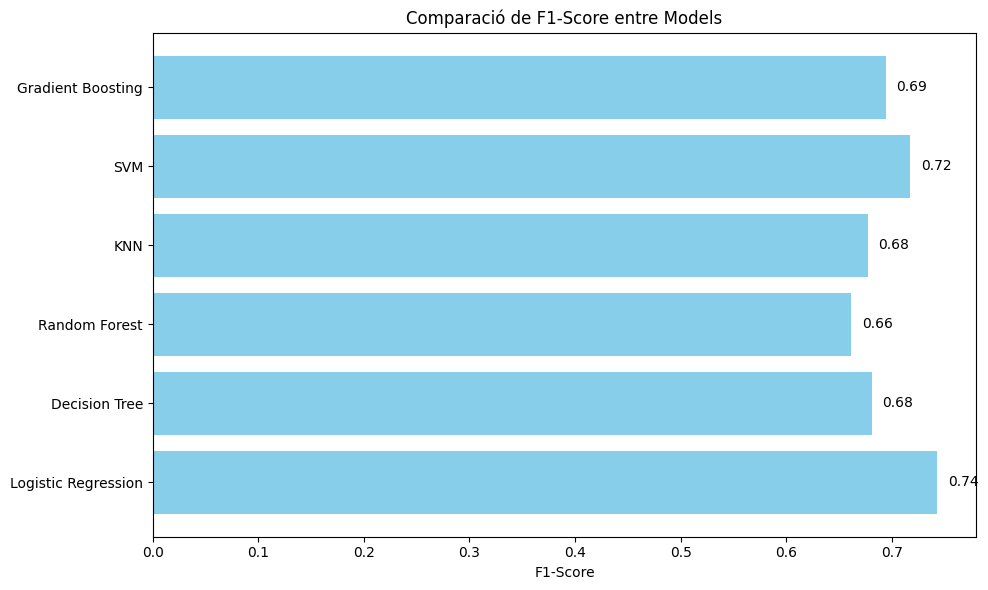

In [331]:
f1_score_comparison(models, f1_scores)

VALIDACIO CREUADA: trobem el millor model amb els hiperparametres per defecte.

En el nostre cas és millor utilitzar la StratifiedKFold, ja que garanteix que cada "fold" tingui una distribució similar de la classe objectiu (la proporció de supervivents i no supervivents es manté constant).

Com funciona?
Exemple amb k = 5 folds:
- Iteració 1: El model s'entrena amb els folds 2, 3, 4, i 5, i es valida amb el fold 1.
- Iteració 2: El model s'entrena amb els folds 1, 3, 4, i 5, i es valida amb el fold 2.
- Iteració 3: El model s'entrena amb els folds 1, 2, 4, i 5, i es valida amb el fold 3.
- Iteració 4: El model s'entrena amb els folds 1, 2, 3, i 5, i es valida amb el fold 4.
- Iteració 5: El model s'entrena amb els folds 1, 2, 3, i 4, i es valida amb el fold 5.

Nosaltres hem anat adaptant a cada model millor K-fold que obtenia millors resultats.

Logistic Regression: F1 score mitjana en CV = 0.7334
SVM: F1 score mitjana en CV = 0.7484
Random Forest: F1 score mitjana en CV = 0.7547
KNN: F1 score mitjana en CV = 0.7269
Gradient Boosting Classifier: F1 score mitjana en CV = 0.7488
Decision Tree Classifier: F1 score mitjana en CV = 0.6964


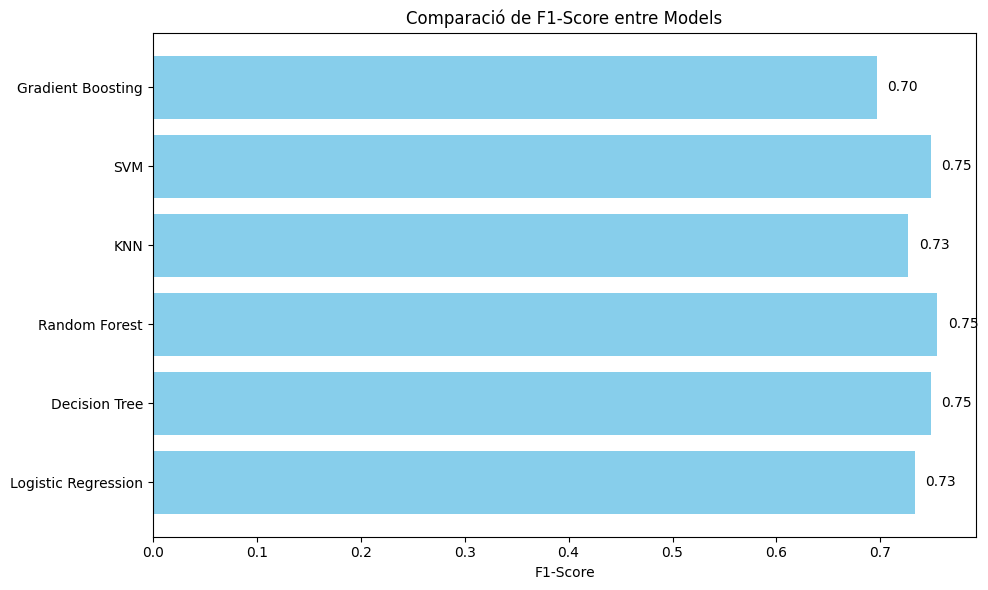

In [336]:
models2 = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier()
}
f1_scores=[]
for name, model in models2.items():
    scores = cross_val_score(model, X_train, y_train, cv = StratifiedKFold(n_splits = 5), scoring = 'f1')
    print(f'{name}: F1 score mitjana en CV = {scores.mean():.4f}')
    f1_scores.append(scores.mean())

f1_score_comparison(models, f1_scores)


Podem veure que obtenim millors resultats amb el model de Random Forest, tenint en compte els hiperparametres per defecte.

HYPERPARAMETRES

Trobem els millors hiperparametres per cada model utilitzant VC i Grid search.  També són bones opcions Random Search per tenir una cerca eficient i ràpida, sense complicacions addicionals o Bayesian Search, si es vol optimitzar al màxim amb menys proves.

LOGISTIC REGRESSION

In [219]:
#provem amb l2
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularització
    'penalty': ['l2'],# Tipus de penalització ('l1', 'l2')
    'solver': ['lbfgs', 'liblinear'] # Algoritmes compatibles amb l2
}

lr = LogisticRegression()

start_time = time.time()
grid_search_log2 = GridSearchCV(lr, param_grid, scoring='f1', cv = StratifiedKFold(n_splits = 10), verbose=3, n_jobs=32)
grid_search_log2.fit(X_train, y_train)
end_time = time.time() 

elapsed_time = end_time - start_time
print(f"Temps d'execució: {elapsed_time} segons")
print(f'Millors hiperparàmetres: {grid_search_log2.best_params_}')
print(f'Millor score: {grid_search_log2.best_score_:.4f}')


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Temps d'execució: 9.178021907806396 segons
Millors hiperparàmetres: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Millor score: 0.7415


In [98]:
#provem amb l1
param_grid = {
    'C': np.arange(0.1,3,0.1),  # Regularització
    'penalty': ['l1'],# Tipus de penalització ('l1', 'l2')
    'solver': ['liblinear'] # Algoritmes compatibles amb l2
}

lr = LogisticRegression()

start_time = time.time()
grid_search_log = GridSearchCV(lr, param_grid, scoring='f1', cv = StratifiedKFold(n_splits = 10), verbose=3, n_jobs=32)
grid_search_log.fit(X_train, y_train)
end_time = time.time() 

elapsed_time = end_time - start_time
print(f"Temps d'execució: {elapsed_time} segons")
print(f'Millors hiperparàmetres: {grid_search_log.best_params_}')
print(f'Millor score: {grid_search_log.best_score_:.4f}')

Fitting 10 folds for each of 29 candidates, totalling 290 fits
Temps d'execució: 0.6721596717834473 segons
Millors hiperparàmetres: {'C': 2.2, 'penalty': 'l1', 'solver': 'liblinear'}
Millor score: 0.7372


C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mn_ts_scores.append(row[1])
C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_tmp = pd.DataFrame(row[0], index=[0])


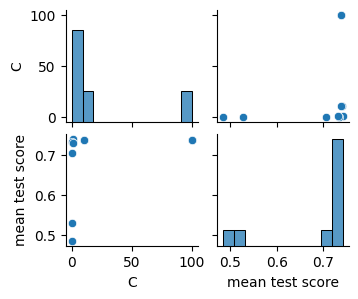

In [271]:
grid_graph(grid_search_log2)

DECISION TREE

In [101]:
param_grid = {
    'criterion': ['gini', 'entropy','log_loss'],  # Criteris de divisió
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profunditat màxima de l'arbre
    'min_samples_split': [2, 5, 10],  # Mínim de mostres per dividir un node
    'min_samples_leaf': [1, 2, 4],  # Mínim de mostres per fulla
}
dt = DecisionTreeClassifier()

start_time = time.time()
grid_search_dt = GridSearchCV(dt, param_grid, scoring='f1', cv = StratifiedKFold(n_splits = 20), verbose=3, n_jobs=32)
grid_search_dt.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Temps d'execució: {elapsed_time} segons")
print(f'Millors hiperparàmetres: {grid_search_dt.best_params_}')
print(f'Millor score: {grid_search_dt.best_score_:.4f}')

Fitting 20 folds for each of 162 candidates, totalling 3240 fits
Temps d'execució: 4.93149209022522 segons
Millors hiperparàmetres: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Millor score: 0.7389


c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mn_ts_scores.append(row[1])
C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_tmp = pd.DataFrame(row[0], index=[0])


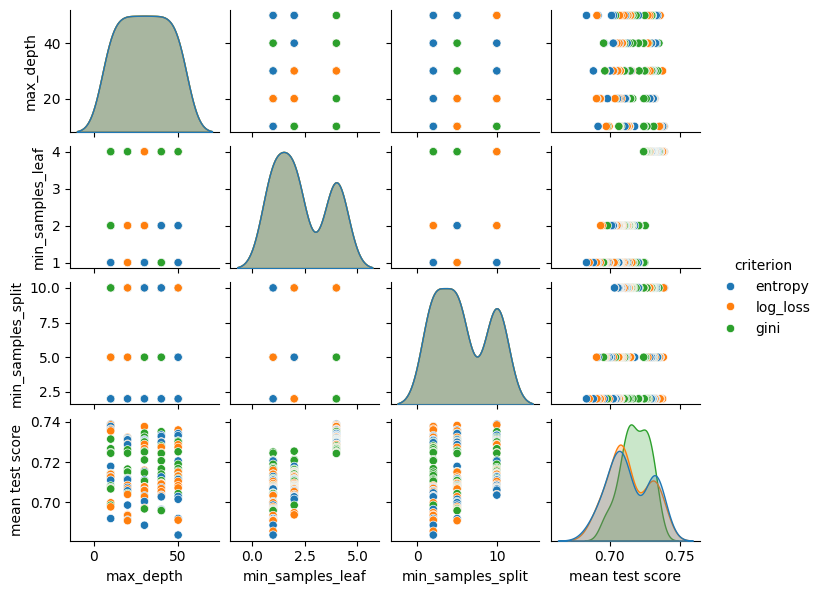

In [272]:
grid_graph(grid_search_dt, 'criterion')


RANDOM FOREST CLASSIFIER

In [222]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini','log_loss', 'entropy']
}

rf=RandomForestClassifier()
start_time = time.time()
grid_search_rf = GridSearchCV(rf, param_grid, scoring='f1', cv = StratifiedKFold(n_splits = 10), verbose=3, n_jobs=32)
grid_search_rf.fit(X_train, y_train)
end_time = time.time() 
elapsed_time = end_time - start_time
print(f"Temps d'execució: {elapsed_time} segons")
print(f'Millors hiperparàmetres per Random Forest: {grid_search_rf.best_params_}')
print(f'Millor score: {grid_search_rf.best_score_:.4f}')


Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Temps d'execució: 53.2245147228241 segons
Millors hiperparàmetres per Random Forest: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Millor score: 0.7772


C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mn_ts_scores.append(row[1])
C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_tmp = pd.DataFrame(row[0], index=[0])


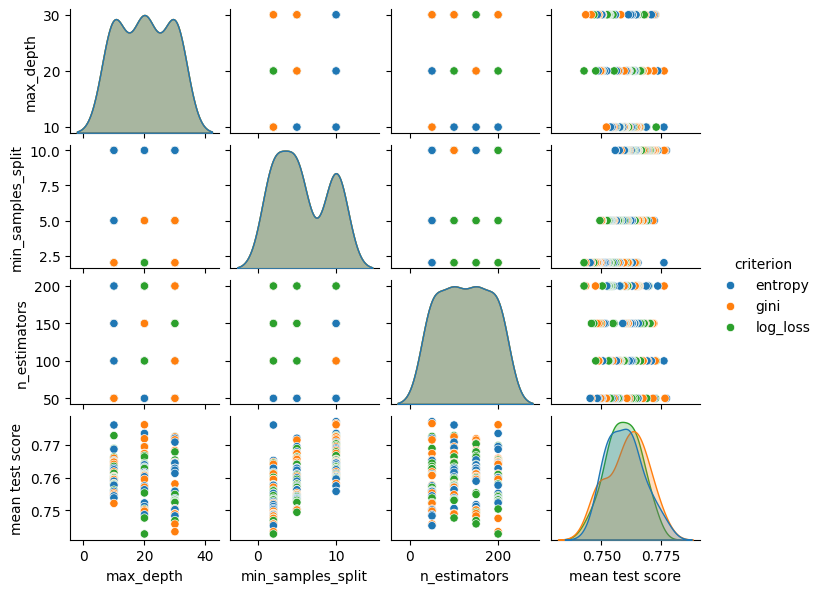

In [273]:
grid_graph(grid_search_rf, 'criterion')

KNN

In [105]:
param_grid = {
    'n_neighbors': [3, 4, 5, 6, 7, 9, 8, 9, 10, 11, 12, 13, 14],  # Provar diversos valors per a 'k'
    'weights': ['uniform', 'distance'], # Ponderació uniforme o per distància
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Diferents mètodes de 
}

knn=KNeighborsClassifier()
start_time = time.time()
grid_search_knn = GridSearchCV(knn, param_grid, scoring='f1', cv = StratifiedKFold(n_splits = 10), verbose=3, n_jobs=32)
grid_search_knn.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Temps d'execució: {elapsed_time} segons")
print(f'Millors hiperparàmetres: {grid_search_knn.best_params_}')
print(f'Millor score: {grid_search_knn.best_score_:.4f}')

Fitting 10 folds for each of 78 candidates, totalling 780 fits
Temps d'execució: 1.6828114986419678 segons
Millors hiperparàmetres: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Millor score: 0.7436


C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mn_ts_scores.append(row[1])
C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_tmp = pd.DataFrame(row[0], index=[0])


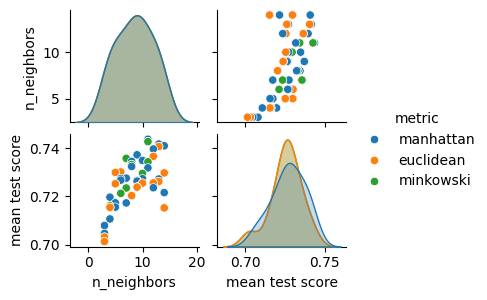

In [274]:
grid_graph(grid_search_knn, 'metric')

SVM

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 50, 100, 1000],  # Regularització
    'kernel': ['rbf'],  # Tipus de kernel
    'gamma': [1,0.1,0.01,0.001,0.0001],  # Paràmetre gamma per a rbf/poly
}

svc = SVC()
start_time = time.time()
grid_search_svc = GridSearchCV(svc, param_grid, cv=StratifiedKFold(n_splits = 10), scoring='f1')
grid_search_svc.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Temps d'execució: {elapsed_time} segons")
print(f'Millors hiperparàmetres: {grid_search_svc.best_params_}')
print(f'Millor score: {grid_search_svc.best_score_:.4f}')


Temps d'execució: 17.1948881149292 segons
Millors hiperparàmetres: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Millor score: 0.7668


C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mn_ts_scores.append(row[1])
C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_tmp = pd.DataFrame(row[0], index=[0])


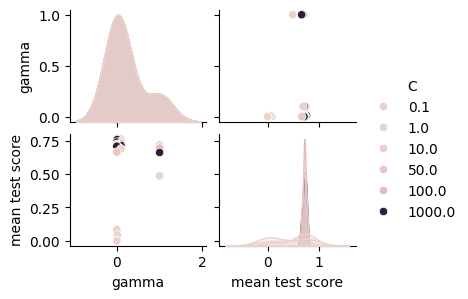

In [275]:
grid_graph(grid_search_svc, 'C')

GRADIENT BOOSTING

In [237]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'n_estimators': [100, 150, 200],  # Nombre d'arbres
    'learning_rate': [0.01, 0.1, 0.2],  # Taxa d'aprenentatge
    'max_depth': [3, 4, 5],  # Profunditat màxima dels arbres
    'subsample': [0.8, 1.0],  # Submostra per entrenar cada arbre
    'min_samples_split': [2, 5, 10]  # Nombre mínim de mostres per dividir un node
}

gb = GradientBoostingClassifier()
start_time = time.time()
grid_search_gb = GridSearchCV(gb, param_grid, cv=StratifiedKFold(n_splits = 5), scoring='f1')
grid_search_gb.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Temps d'execució: {elapsed_time} segons")
print(f'Millors hiperparàmetres: {grid_search_gb.best_params_}')
print(f'Millor score: {grid_search_gb.best_score_:.4f}')

Temps d'execució: 376.8545916080475 segons
Millors hiperparàmetres: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.8}
Millor score: 0.7710


C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mn_ts_scores.append(row[1])
C:\Users\nerea\AppData\Local\Temp\ipykernel_7384\1500779665.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_tmp = pd.DataFrame(row[0], index=[0])


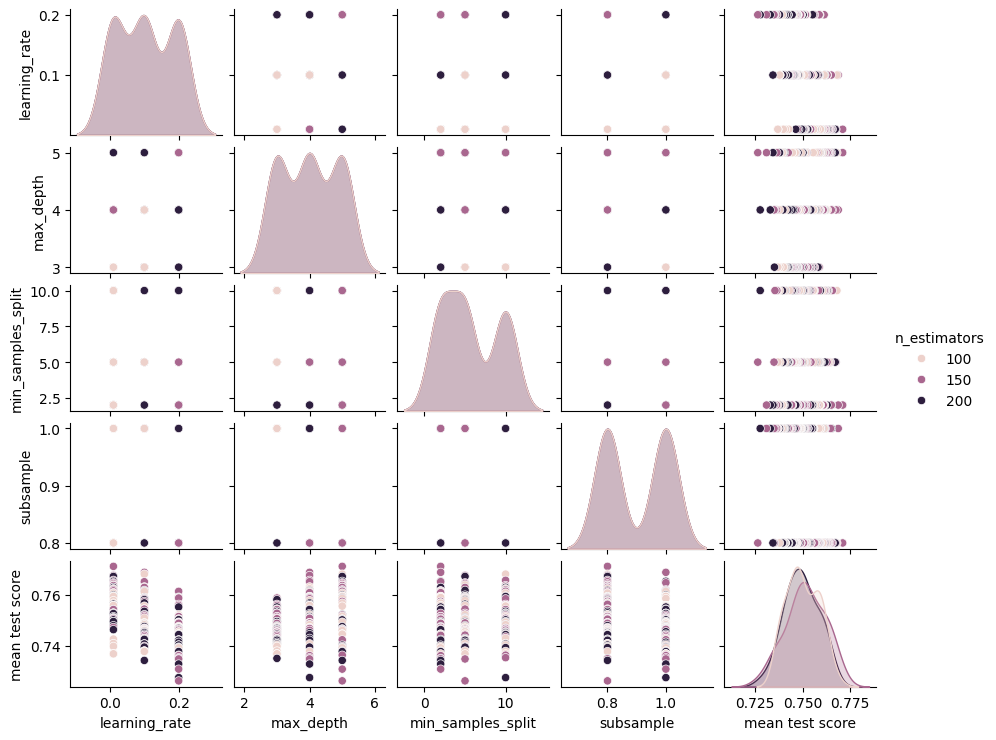

In [276]:
grid_graph(grid_search_gb, 'n_estimators')

### 5.Analisi Final (1.5 punt)

Un cop seleccionat el millor model amb els millors hiperparamtres, caldra fer un report final amb els resultats obtinguts.

Preguntes:
* Mostreu les curves ROC/PR (la que hageu escollit en l'apartat 2) i interpreteu els resultats.

* Analitzeu en detall les diferents metriques que trobeu adients i comenteu per sobre com podrieu fer servir aquest model en un futur. Aixo es el que es coneix com un cas d'us.

* Com creieu que es podria millorar el vostre model?

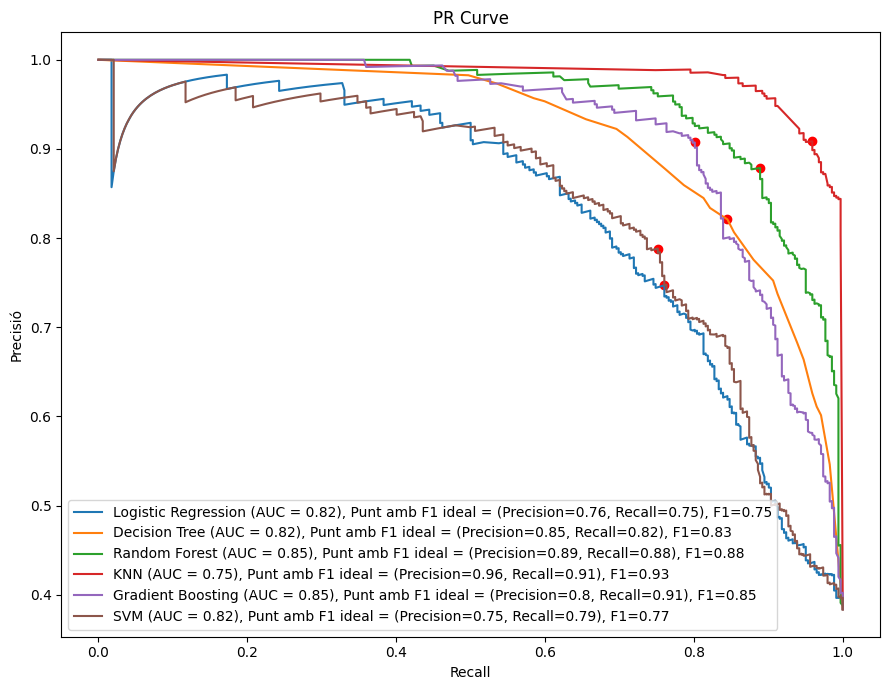

In [225]:
X = train_norm.drop('Survived', axis=1)
y = train_norm['Survived']
classifiers = [
    ("Logistic Regression", LogisticRegression(C= 1, penalty= 'l2', solver= 'lbfgs')),
    ("Decision Tree", DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, min_samples_leaf= 4, min_samples_split= 10)),
    ("Random Forest", RandomForestClassifier(criterion= 'entropy', max_depth= 10, min_samples_split= 4, n_estimators= 50)),
    ("KNN", KNeighborsClassifier(metric= 'manhattan', n_neighbors= 11, weights= 'distance')),
    ("Gradient Boosting", GradientBoostingClassifier(learning_rate= 0.01, max_depth= 5, min_samples_split= 5, n_estimators= 100, subsample= 0.8)),
    ("SVM", SVC(C= 100, gamma= 0.01, kernel= 'rbf', probability=True)),
]
plot_pr_curve(classifiers, X, y, 5)

Models amb millor rendiment general: Random Forest i Gradient Boosting tenen els millors resultats tant en termes d’AUC com de F1-Score. Aquests models són molt adequats quan es busca un equilibri entre precisió i recall en un problema de classificació.
Models com SVM i Regressió Logística: Tot i que tenen bons resultats, no són tan competitius com els models basats en arbres en aquest cas.

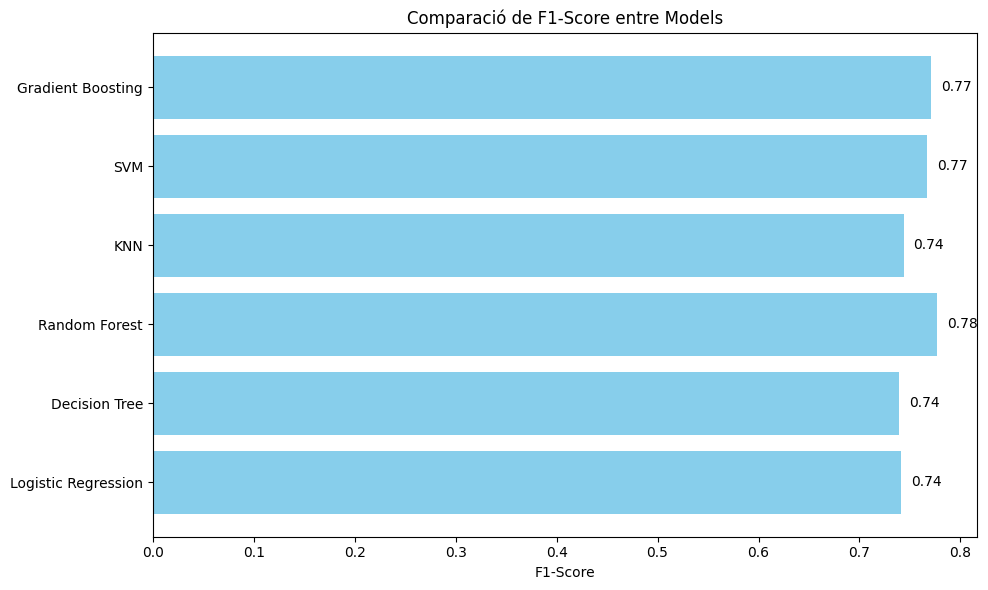

In [277]:
models=['Logistic Regression', "Decision Tree", 'Random Forest', 'KNN', 'SVM', 'Gradient Boosting']
f1_scores=[grid_search_log2.best_score_, 
        grid_search_dt.best_score_, 
        grid_search_rf.best_score_, 
        grid_search_knn.best_score_, 
        grid_search_svc.best_score_, 
        grid_search_gb.best_score_]
f1_score_comparison(models, f1_scores)

Mirem f1-scores pels train:

In [335]:
f1=calculate_f1_score("LogisticRegression", LogisticRegression(C= 1, penalty= 'l2', solver= 'lbfgs'), X_train, y_train, X_test, y_test)
print(f1[0])
f1=calculate_f1_score("Random Forest Classifier", RandomForestClassifier(criterion= 'entropy', max_depth= 10, min_samples_leaf= 4, min_samples_split= 5, n_estimators=100), X_train, y_train, X_test, y_test)
print(f1[0])
f1=calculate_f1_score("Decision Tree Classifier", DecisionTreeClassifier(criterion= 'log_loss', max_depth= 10, min_samples_split= 4), X_train, y_train, X_test, y_test)
print(f1[0])
f1=calculate_f1_score("KNeighbors Classifier", KNeighborsClassifier(metric= 'manhattan', n_neighbors= 11, weights= 'distance'), X_train, y_train, X_test, y_test)
print(f1[0])
f1=calculate_f1_score("SVC", SVC(C= 100, gamma= 0.01, kernel= 'rbf'), X_train, y_train, X_test, y_test)
print(f1[0])
f1=calculate_f1_score("Gradient Boosting Classifier", GradientBoostingClassifier(learning_rate= 0.01, max_depth= 4, min_samples_split= 2, n_estimators= 150, subsample= 1), X_train, y_train, X_test, y_test)
print(f1[0])

LogisticRegression f1_test: 0.74286
0.746615087040619
Random Forest Classifier f1_test: 0.66667
0.835030549898167
Decision Tree Classifier f1_test: 0.66165
0.896414342629482
KNeighbors Classifier f1_test: 0.70504
0.9830508474576272
SVC f1_test: 0.72727
0.7858546168958742
Gradient Boosting Classifier f1_test: 0.66667
0.7974683544303798


La taula amb tots els models, scores i temps està adjunta a l'informe.